In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import json
import os
import gc
import numpy as np
import sys
import torch
from torch import nn
from typing import List
import glob
import faiss

from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from builder import MoCo

import argparse
from datasets import Pair
from builder import MoCo
from extraction import FeatureExtractor
from encoder import Net

from guided_diffusion.guided_diffusion.script_util import model_and_diffusion_defaults, classifier_defaults, add_dict_to_argparser


In [2]:
parser = argparse.ArgumentParser()
add_dict_to_argparser(parser, model_and_diffusion_defaults())
command = "--attention_resolutions 32,16,8 --class_cond False --diffusion_steps 1000 --dropout 0.1 --image_size 256 --learn_sigma True --noise_schedule linear --num_channels 256 --num_head_channels 64 --num_res_blocks 2 --resblock_updown True --use_fp16 True --use_scale_shift_norm True"
args = parser.parse_args(command.split(" "))

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
def vis_map(maps, size):
    maps = maps.reshape(-1, size * size * 20).transpose(1, 0)
    # maps = maps.reshape(size * size, -1)
    
    # maps = maps / (np.linalg.norm(maps, axis=1, keepdims=True) + 1e-6)

    pca = PCA(n_components=3, random_state=0)
    maps = pca.fit_transform(maps)
    trans = QuantileTransformer()
    maps = trans.fit_transform(maps)
    
    return maps.reshape(size, size * 20, -1)

In [82]:
opts = {
    "model_type": "ddpm",
    "dim": [256, 256, 8448],
    "steps": [150],
    "blocks": [5,6,7,8,12],
    "model_path": "checkpoints/ddpm/ffhq.pt",
    "input_activations": False,
    "upsample_mode":"bilinear",
}
opts.update(vars(args))
opts['image_size'] = opts['dim'][0]
feature_extractor = FeatureExtractor(**opts)

Pretrained model is successfully loaded from checkpoints/ddpm/ffhq.pt


In [88]:
files = sorted(glob.glob("datasets/ffhq/train/*"))[:20]

In [30]:
model = MoCo(Net, K=81920)
checkpoint = torch.load("checkpoints/99.pth.tar")
model.load_state_dict(checkpoint["state_dict"])
model = model.cuda().eval()

In [32]:
val_dataset = Pair(opts, files, feature_extractor, train=False)
xs = []
for k in range(len(val_dataset)):
    x, _ = val_dataset[k]
    x = x.unsqueeze(0).cuda(1)
    # x = torch.nn.functional.interpolate(x, (64, 64), mode="bilinear")
    x = model.encoder_q.net(x)
    xs.append(x.detach().cpu().numpy()[0])

In [85]:
def colorize_mask(mask, palette):
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)
    return np.array(new_mask.convert('RGB'))

palette = sum(
[
[230,230,230],
[170,210,245],
[230,160,160],
[230,210,130],
# [160,180,200],
# [255, 0, 0],
# [0, 255, 0],
# [0, 0, 255]
],
[])

In [86]:

dim = 128

example = np.stack(xs, axis=0)
example = np.concatenate([example], axis=1)

example = example.transpose(0, 2, 3, 1).reshape(-1, dim)
kmeans = faiss.Kmeans(dim, 4, niter=200, gpu=True, spherical=False) 
kmeans.train(example)
label = kmeans.assign(example)[1].reshape(20, 256, 256)
    

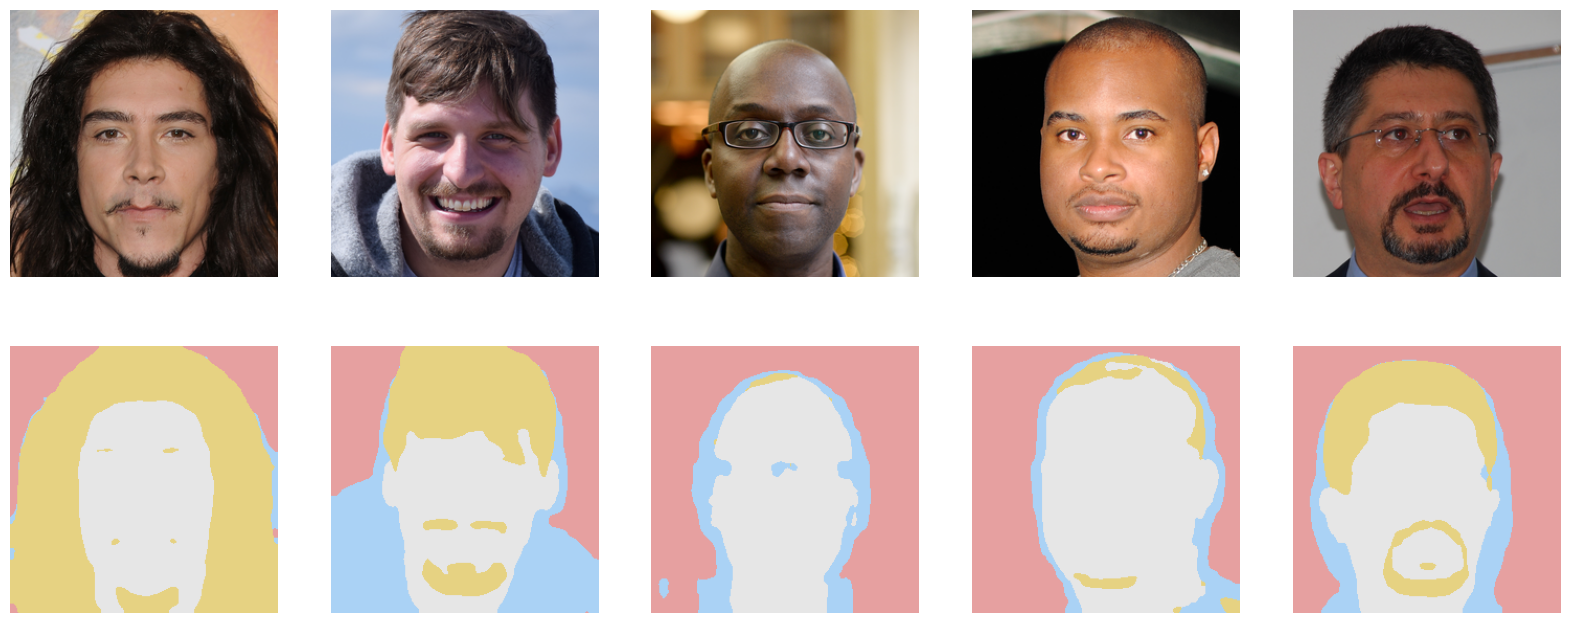

In [87]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
sample = [0, 1, 2, 5, 4]
for i in range(5):
    z = sample[i]
    ax[0, i].imshow(Image.open(files[z]))
    ax[1, i].imshow(colorize_mask(label[z], palette))

    ax[0, i].axis('off')

    ax[1, i].axis('off')

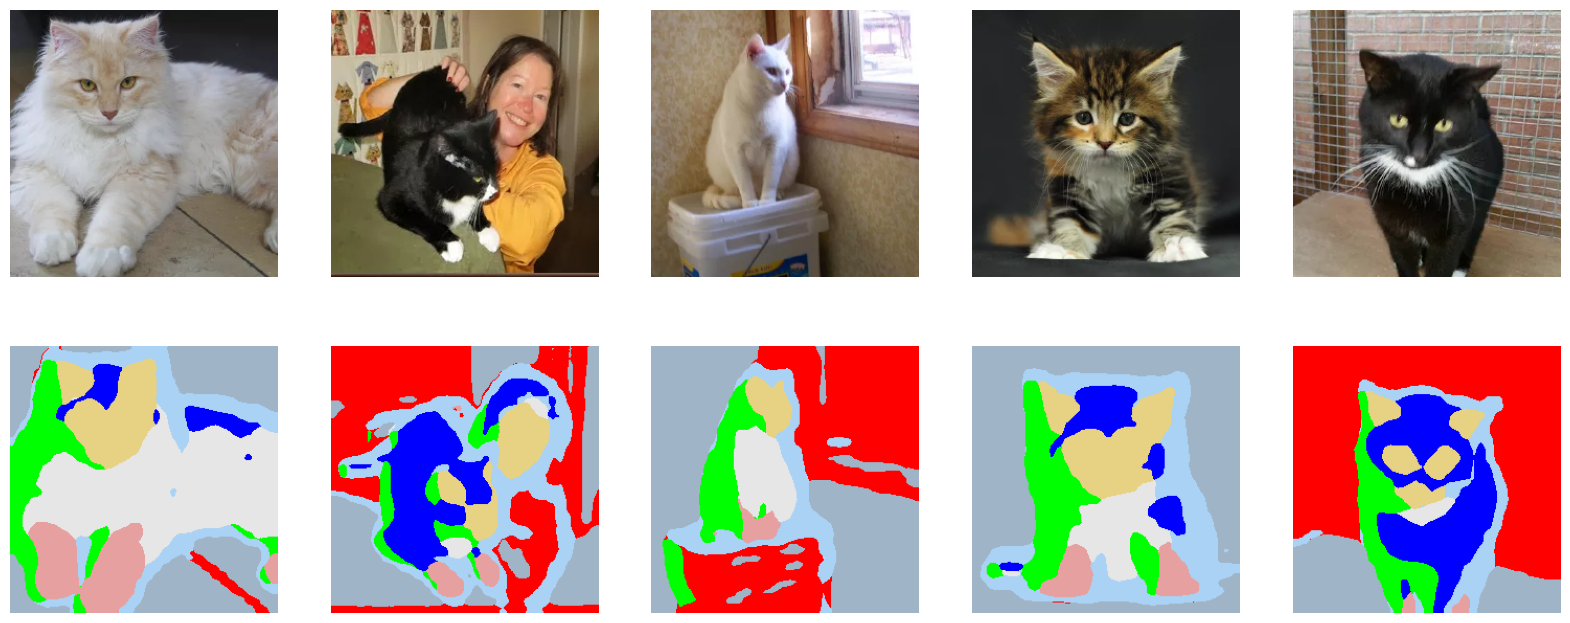

In [16]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for z in range(5):
    ax[0, z].imshow(Image.open(files[z +10]))
    ax[1, z].imshow(colorize_mask(label[z + 10], palette))
    ax[0, z].axis('off')

    ax[1, z].axis('off')